In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,rmsprop,Adadelta
from keras.metrics import categorical_crossentropy
from batch_generator import batch_generator
from metrics import (dice_coef,dice_loss,categorical_loss)
from models import create
from model_2pathed import create_2pathed
from model_2pathed_shallow import create_2pathed_shallow
from image_generator import generate_image
from glob import glob
import os


: 

In [16]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [10]:
samples_paths=sorted(glob("./Data/Train/samples_processed/*.npy"))
masks_paths=sorted(glob("./Data/Train/masks_reformatted/*.npy"))


In [11]:
samples_paths

['./Data/Train/samples_processed\\sample_001.npy',
 './Data/Train/samples_processed\\sample_002.npy',
 './Data/Train/samples_processed\\sample_003.npy',
 './Data/Train/samples_processed\\sample_004.npy',
 './Data/Train/samples_processed\\sample_005.npy',
 './Data/Train/samples_processed\\sample_006.npy',
 './Data/Train/samples_processed\\sample_007.npy',
 './Data/Train/samples_processed\\sample_008.npy',
 './Data/Train/samples_processed\\sample_009.npy',
 './Data/Train/samples_processed\\sample_010.npy',
 './Data/Train/samples_processed\\sample_011.npy',
 './Data/Train/samples_processed\\sample_012.npy',
 './Data/Train/samples_processed\\sample_013.npy',
 './Data/Train/samples_processed\\sample_014.npy',
 './Data/Train/samples_processed\\sample_015.npy',
 './Data/Train/samples_processed\\sample_016.npy',
 './Data/Train/samples_processed\\sample_017.npy',
 './Data/Train/samples_processed\\sample_018.npy',
 './Data/Train/samples_processed\\sample_019.npy',
 './Data/Train/samples_processe

In [26]:
train_sample_paths,test_sample_paths=train_test_split(samples_paths,test_size=0.25)

In [27]:
len(train_sample_paths)

276

In [28]:
traingen=batch_generator(train_sample_paths,16) #Mini batch size of 16
testgen=batch_generator(test_sample_paths,16)


In [18]:
model=create_2pathed_shallow()

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 126, 126, 12  656         ['input_1[0][0]']                
                                6, 8)                                                             
                                                                                                  
 conv3d_6 (Conv3D)              (None, 126, 126, 12  656         ['input_1[0][0]']                
                                6, 8)                                                         

In [31]:
sample,mask=next(traingen)

In [32]:
sample.shape

(16, 128, 128, 128, 3)

In [33]:
mask.shape

(16, 2097152, 4)

In [34]:
#Compute steps per epoch
def steps(m,batchsize):
    return (m+batchsize-1)//batchsize

In [35]:
train_steps=steps(len(train_sample_paths),16)
test_steps=steps(len(test_sample_paths),16)


In [36]:
train_steps

18

In [37]:
import datetime

In [38]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [39]:
history=model.fit(traingen,steps_per_epoch=train_steps,epochs=1,validation_data=testgen,validation_steps=test_steps,verbose=1,callbacks=[tensorboard_callback])


 1/18 [>.............................] - ETA: 9:29:09 - loss: 1.9935 - categorical_accuracy: 0.0149

Text(0.5, 1.0, 'Learning curve')

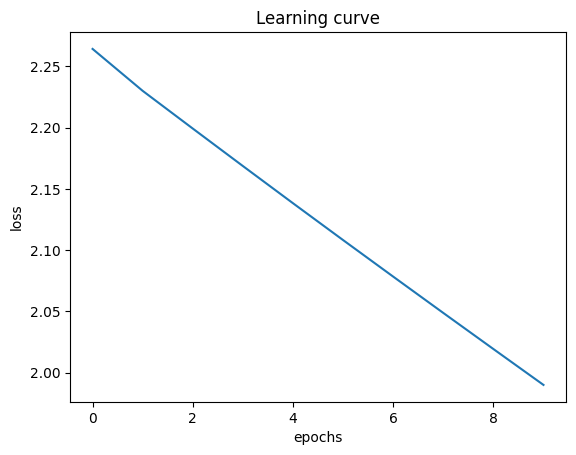

In [19]:
plt.plot(history.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Learning curve") 

#Comments : base cnn model -> learning rate too quick, develop deeper architecture